## Survival Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [97]:
df = pd.read_csv('romans 2 (1).csv')

In [98]:
df.head()

,Name,Birth,Succession,Reign,Time,Deaths
0,Augustus IMPERATOR CAESAR DIVI FILIVS AVGVST...,"23 September 63 BC, Rome , Italia \n",Great-nephew and adopted son of Julius Caesa...,16 January 27 BC – 19 August 14 AD\n,"40 years, 7 months and 3 days\n",19 August 14 AD (aged 75) Natural causes \n
1,Tiberius TIBERIVS CAESAR DIVI AVGVSTI FILIVS...,"16 November 42 BC, Rome , Italia \n","Natural son of Livia Drusilla , Augustus' th...",18 September 14 AD – 16 March 37 AD\n,"22 years, 5 months and 27 days\n",16 March 37 AD (aged 77) Probably natural cau...
2,Caligula GAIVS IVLIVS CAESAR AVGVSTVS GERMANI...,"31 August 12 AD, Antium , Italia \n",Great-nephew and adoptive grandson of Tiberiu...,18 March 37 AD – 24 January 41 AD\n,"3 years, 10 months and 6 days\n",24 January 41 AD (aged 28) Assassinated in a ...
3,Claudius TIBERIVS CLAVDIVS CAESAR AVGVSTVS ...,"1 August 10 BC, Lugdunum , Gallia Lugdunens...",Uncle of Caligula; brother of Germanicus; nep...,25/26 January 41 AD – 13 October 54 AD\n,"13 years, 8 months and 18/19 days\n",13 October 54 AD (aged 63) Probably poisoned ...
4,Nero NERO CLAVDIVS CAESAR AVGVSTVS GERMANICV...,"15 December 37 AD, Antium , Italia \n","Great-nephew, stepson, son-in-law and adopted...",13 October 54 AD – 9 June 68 AD\n,"13 years, 7 months and 27 days\n",9 June 68 AD (aged 30) Committed suicide afte...


In [99]:
print(f"Total number of emperors: {df.shape[0]}")
print(f"Total number of raw features: {df.shape[1]}")
print(f"Features available: {list(df.columns)}")

Total number of emperors: 174
Total number of raw features: 6
Features available: ['Name', 'Birth', 'Succession', 'Reign', 'Time', 'Deaths']


We use regex to extract meaningful features from the raw data. It's a good alternative to manually iterating and extracting information from individual rows. Note that years before AD (year zero) are encoded as a negative integer. The process is not 100% robust yet, as the output still has a few outliers due to the messiness of the raw data

In [100]:
# Make all columns lowercase except the names
for col in df.columns:
    if col != "Name":
        df[col] = df[col].str.lower()
    
# Drop Succession column
if 'Succession' in df:
    df = df.drop(['Succession'], axis=1)

# Extract age of death and replace missing values
death_age = df['Deaths'].str.extract('\((.*?)\)').apply(lambda x: x.str.strip())
df['AgeOfDeath'] = death_age[0].astype(str).map(lambda x: x.lstrip('aged ').strip())

df['AgeOfDeath'].replace(to_replace ="?", value ="0", inplace=True) 
df['AgeOfDeath'].replace(to_replace ="nan", value ="0", inplace=True) 

# Extract Reign in years
df['ReignYears'] = df['Time'].str.extract('(\d+).(?=years|year)').fillna(0)

# Extract Reign in months
df['ReignMonths'] = df['Time'].str.extract('(\d+).(?=months|month)').fillna(0)

# Extract Reign in days
df['ReignDays'] = df['Time'].str.extract('(\d+).(?=days|day)').fillna(0)

# Extract birth name
df['BirthName'] = df['Name'].str.extract('(.[a-z]+)')

# Extract title
df['Title'] = df['Name'].str.extract('(.[A-Z]{2,})')

# Extract cause of death
df['CauseOfDeath'] = df['Deaths'].str.extract('\).(.*)').fillna('Unknown')
df['CauseOfDeath'] = df['CauseOfDeath'].apply(lambda x: x.replace('  ', ' ').strip())

# Extract birth year (caring for AD/BC)
df['BirthYearBC'] = df['Birth'].str.extract('(\d+.(?=bc))').fillna(0).astype(str)
df['BirthYearAD'] = df['Birth'].str.extract('(\d+.(?=,|ad))').fillna(0).astype(str)
df['BirthYearNum'] = df['Birth'].str.extract('(\d+(?:\.\d+)?)').fillna(0).astype(str)
df['BirthYearAD'] = df['BirthYearAD'].apply(lambda x: x.replace(',', '').replace('/', '')).astype(int)

def add_year_prefix(row):
    year_bc = int(row['BirthYearBC'])
    if year_bc > 0:
        return -year_bc
    else:
        return int(row['BirthYearAD'])
    
def add_num_year(row):
    if row['BirthYear'] is 0:
        return row['BirthYearNum']
    else:
        return row['BirthYear']
    
df['BirthYear'] = df.apply(add_year_prefix, axis=1)
df['BirthYear'] = df.apply(add_num_year, axis=1)
df = df.drop(['BirthYearNum', 'BirthYearBC', 'BirthYearAD'], axis=1)

# Extract birth day
df['BirthDay'] = df['Birth'].str.extract('(\d+)').fillna(0)

# Extract birth month
df['BirthMonth'] = df['Birth'].str.split(',', 1).str[0].str.extract('([a-zA-Z]{5,})').fillna('Unknown')
df['BirthMonth'] = df['BirthMonth'].str.capitalize()

# Extract reign start and end year (manual handle the BC case)
df['ReignStartYear'] = df['Reign'].str.split('–', 1).str[0].str.extract('(\d+.(?=ad|bc)|\d{4})')
df['ReignEndYear'] = df['Reign'].str.split('–', 1).str[1].str.extract('(\d+.(?=ad|bc)|\d{4})')
df.at[0, 'ReignStartYear'] = int('-' + df['ReignStartYear'].iloc[0].strip())

# Extract reign day
df['ReignStartDay'] = df['Reign'].str.split('–', 1).str[0].str.extract('(\d+).(?=[a-zA-Z])')
df['ReignEndDay'] = df['Reign'].str.split('–', 1).str[1].str.extract('(\d+).(?=[a-zA-Z])')

# Extract reign start month
df['ReignStartMonth'] = df['Reign'].str.split('–', 1).str[0].str.extract('([a-zA-Z]+)')
df['ReignStartMonth'] = df['ReignStartMonth'].str.capitalize()

# Extract reign end month
df['ReignEndMonth'] = df['Reign'].str.split('–', 1).str[1].str.extract('([a-zA-Z]+)')
df['ReignEndMonth'] = df['ReignEndMonth'].str.capitalize()

# Drop handled columns
df = df.drop(['Name', 'Birth', 'Time', 'Deaths', 'Reign'], axis=1)

In [101]:
df.head()

,AgeOfDeath,ReignYears,ReignMonths,ReignDays,BirthName,Title,CauseOfDeath,BirthYear,BirthDay,BirthMonth,ReignStartYear,ReignEndYear,ReignStartDay,ReignEndDay,ReignStartMonth,ReignEndMonth
0,75,40,7,3,Augustus,IMPERATOR,natural causes,-63,23,September,-27,14,16,19,January,August
1,77,22,5,27,Tiberius,TIBERIVS,"probably natural causes, possibly assassinated...",-42,16,November,14,37,18,16,September,March
2,28,3,10,6,Caligula,GAIVS,assassinated in a conspiracy involving senator...,12,31,August,37,41,18,24,March,January
3,63,13,8,19,Claudius,TIBERIVS,probably poisoned by his wife agrippina the yo...,-10,1,August,41,54,26,13,January,October
4,30,13,7,27,Nero,NERO,committed suicide after being declared a publi...,37,15,December,54,68,13,9,October,June


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 16 columns):
AgeOfDeath         174 non-null object
ReignYears         174 non-null object
ReignMonths        174 non-null object
ReignDays          174 non-null object
BirthName          174 non-null object
Title              149 non-null object
CauseOfDeath       174 non-null object
BirthYear          174 non-null object
BirthDay           174 non-null object
BirthMonth         174 non-null object
ReignStartYear     51 non-null object
ReignEndYear       52 non-null object
ReignStartDay      93 non-null object
ReignEndDay        98 non-null object
ReignStartMonth    164 non-null object
ReignEndMonth      163 non-null object
dtypes: object(16)
memory usage: 21.9+ KB


In [103]:
# Print a few causes of death

for i in range(0,10,2):
    print(f'{df.BirthName.loc[i]} died of {df.CauseOfDeath.loc[i]}')

Augustus died of natural causes
Caligula died of assassinated in a conspiracy involving senators and praetorian guards
Nero died of committed suicide after being declared a public enemy by the senate
Otho died of committed suicide after losing battle of bedriacum to vitellius
Vespasian died of natural causes


# Analyzing cause of death
Lastly we look at the most occurring cause of death amongst Roman emperors. It seems that, despite popular believe, that many in fact died from natural causes, but Constantinople is mentioned quite a lot as well. Also suicide wasn't that uncommon amongst emperors either.

In [104]:
# Look at the most occuring causes

import spacy
import en_core_web_sm
from collections import Counter

nlp = en_core_web_sm.load()

complete_text = df.CauseOfDeath.str.strip().str.cat(sep=' ')
complete_doc = nlp(complete_text)

words = [token.text for token in complete_doc
         if not token.is_stop and not token.is_punct]
word_freq = Counter(words)

# Print 20 most common words
common_words = word_freq.most_common(20)
print (f'20 most common words: \n{common_words}\n')

# Print all unique words
unique_words = [word for (word, freq) in word_freq.items() if freq == 1]
print (f'Unique words in death notes: \n{unique_words}\n')

C:\Users\Asus\Anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


20 most common words: 
[('natural', 35), ('causes', 35), ('Unknown', 30), ('constantinople', 27), ('assassinated', 16), ('murdered', 16), ('battle', 13), ('possibly', 10), ('praetorian', 9), ('executed', 9), ('suicide', 8), ('killed', 8), ('died', 8), ('probably', 7), ('guard', 7), ('deposed', 7), ('favour', 6), ('committed', 6), ('orders', 6), ('constantine', 6)]

Unique words in death notes: 
['caligula', 'prefect', 'naevius', 'sutorius', 'macro', 'senators', 'guards', 'wife', 'agrippina', 'younger', 'son', 'nero', 'declared', 'public', 'enemy', 'coup', 'led', 'otho', 'losing', 'bedriacum', 'vitellius', 'vespasian', 'fever', 'court', 'officials', 'soldier', 'macrinus', 'caracalla', 'elagabalus', 'men', 'siege', 'hearing', 'gordian', 'carthage', 'pro', 'maximinus', 'verona', 'decius', 'abrittus', 'aemilian', 'valerian', 'edessa', 'persians', 'commanders', 'murder', 'probus', 'carus', 'lightning', 'aspalatos', 'twice', 'tried', 'regain', 'throne', 'forced', 'commit', 'milvian', 'bridge

# Definition of Survival

event=1 -> Assasiation, captivity, execution


event=0 -> in battle, Suicide (more natural ways)

In [105]:
df.CauseOfDeath

0                                         natural causes
1      probably natural causes, possibly assassinated...
2      assassinated in a conspiracy involving senator...
3      probably poisoned by his wife agrippina the yo...
4      committed suicide after being declared a publi...
                             ...                        
169                                         thessaloniki
170                                       constantinople
171                                       constantinople
172                                       constantinople
173                                       constantinople
Name: CauseOfDeath, Length: 174, dtype: object

In [106]:
df['CauseofDeath_Coded'] = pd.np.where(df.CauseOfDeath.str.contains("executed"),1,
                   pd.np.where(df.CauseOfDeath.str.contains("assassinated"), 1,
                   pd.np.where(df.CauseOfDeath.str.contains("captivity"), 1,0)))

In [107]:
df[['CauseOfDeath','CauseofDeath_Coded']]

,CauseOfDeath,CauseofDeath_Coded
0,natural causes,0
1,"probably natural causes, possibly assassinated...",1
2,assassinated in a conspiracy involving senator...,1
3,probably poisoned by his wife agrippina the yo...,0
4,committed suicide after being declared a publi...,0
...,...,...
169,thessaloniki,0
170,constantinople,0
171,constantinople,0
172,constantinople,0


In [108]:
df.isnull().sum()

AgeOfDeath              0
ReignYears              0
ReignMonths             0
ReignDays               0
BirthName               0
Title                  25
CauseOfDeath            0
BirthYear               0
BirthDay                0
BirthMonth              0
ReignStartYear        123
ReignEndYear          122
ReignStartDay          81
ReignEndDay            76
ReignStartMonth        10
ReignEndMonth          11
CauseofDeath_Coded      0
dtype: int64

In [109]:
df.drop(["Title","ReignStartYear","ReignEndYear","ReignStartDay","ReignEndDay","ReignStartMonth","ReignEndMonth"],axis=1,inplace=True)

In [111]:
df.drop(["CauseOfDeath"],axis=1,inplace=True)

In [119]:
data.dropna(inplace=True)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 9 columns):
AgeOfDeath            174 non-null object
ReignYears            174 non-null object
ReignMonths           174 non-null object
ReignDays             174 non-null object
BirthName             174 non-null object
BirthYear             174 non-null object
BirthDay              174 non-null object
BirthMonth            174 non-null object
CauseofDeath_Coded    174 non-null int32
dtypes: int32(1), object(8)
memory usage: 11.7+ KB


In [136]:
df

,AgeOfDeath,ReignYears,ReignMonths,ReignDays,BirthName,BirthYear,BirthDay,BirthMonth,CauseofDeath_Coded
0,75,40,7,3,Augustus,-63,23,September,0
1,77,22,5,27,Tiberius,-42,16,November,1
2,28,3,10,6,Caligula,12,31,August,1
3,63,13,8,19,Claudius,-10,1,August,0
4,30,13,7,27,Nero,37,15,December,0
...,...,...,...,...,...,...,...,...,...
169,38,0,5,0,John,1370,1370,Unknown,0
170,58,0,5,0,John,1332,18,Unknown,0
171,75,34,0,0,Manuel,1350,27,Unknown,0
172,55,23,0,0,John,18,18,December,0


In [121]:
#how many 0s and 1s in original data
np.round(df['CauseofDeath_Coded'].value_counts()/len(data)*100,0)

0    85.0
1    15.0
Name: CauseofDeath_Coded, dtype: float64

In [143]:
## Create a list of Categorical Columns
cat_cols= [i  for i in df.columns if df[i].dtype==object]

In [144]:
## lets have a look at the categories and their distribution in all the categorical columns.

for i in cat_cols:
    print('Column Name: ',i)
    print(df[i].value_counts())
    print('-----------------------------')

Column Name:  AgeOfDeath
0        24
58        7
50        5
42        5
65        4
         ..
76        1
77-78     1
~55       1
~30       1
87        1
Name: AgeOfDeath, Length: 88, dtype: int64
-----------------------------
Column Name:  ReignYears
0     32
1     15
2     14
3     14
13    10
5      7
7      7
6      6
17     5
4      5
8      4
9      4
19     4
16     3
11     3
15     3
22     3
30     3
24     3
20     3
25     3
37     2
34     2
23     2
10     2
14     2
27     2
38     2
48     1
28     1
46     1
21     1
40     1
49     1
45     1
26     1
33     1
Name: ReignYears, dtype: int64
-----------------------------
Column Name:  ReignMonths
0     103
5      11
3       8
6       8
4       7
9       7
2       7
10      7
7       6
8       5
1       3
11      2
Name: ReignMonths, dtype: int64
-----------------------------
Column Name:  ReignDays
0     124
7       4
3       4
27      4
21      4
4       3
28      3
22      3
29      2
24      2
10      2
12      2

In [137]:
X=df['ReignYears']
Y=df["CauseofDeath_Coded"]

# Kaplan-Meier

In [123]:
from lifelines import KaplanMeierFitter

In [124]:
## create an kmf object
kmf = KaplanMeierFitter()

In [141]:
## Fit the data into the model
kmf.fit(X, Y,label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 174 total observations, 148 right-censored observations>

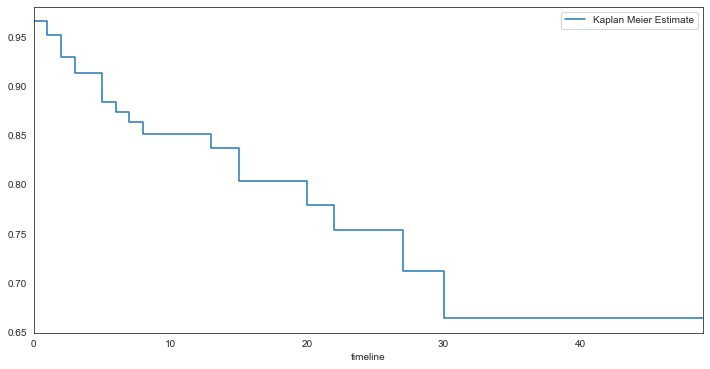

In [142]:
kmf.plot(ci_show=False) ## ci_show is meant for Confidence interval

In [146]:
df['AgeOfDeath']=pd.to_numeric(df['AgeOfDeath'],errors='coerce')

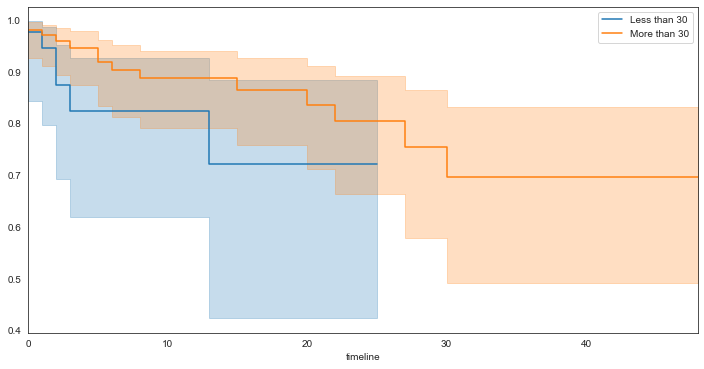

In [154]:
kmf = KaplanMeierFitter() 


X=df['ReignYears']    # time to event
Y=df["CauseofDeath_Coded"]     # event occurred or not


groups = df['AgeOfDeath']    ## Create the cohorts from the 'AgeOfDeath' column
ix1 = (groups <= 30)   ## Cohort 1
ix2 = (groups > 30)   ## Cohort 2



kmf.fit(X[ix1], Y[ix1], label='Less than 30')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(X[ix2], Y[ix2], label='More than 30')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


In [155]:
df['BirthYear']=pd.to_numeric(df['BirthYear'],errors='coerce')

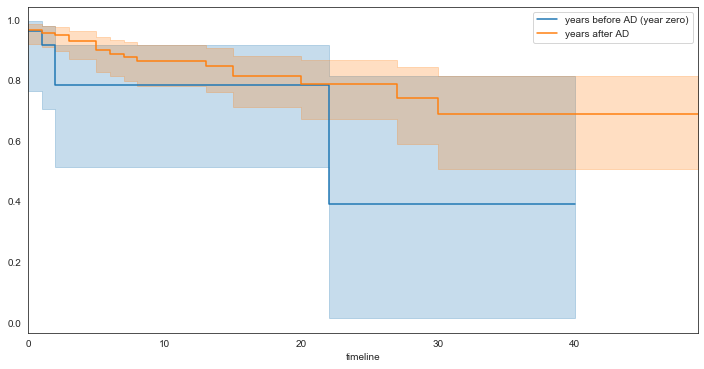

In [156]:
kmf = KaplanMeierFitter() 


X=df['ReignYears']    # time to event
Y=df["CauseofDeath_Coded"]     # event occurred or not


groups = df['BirthYear']    ## Create the cohorts from the 'BirthYear' column
ix1 = (groups <= 0)   ## Cohort 1
ix2 = (groups > 0)   ## Cohort 2



kmf.fit(X[ix1], Y[ix1], label='years before AD (year zero)')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(X[ix2], Y[ix2], label='years after AD')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)
